In [1]:
import kwant
import kwant.continuum
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy

#from IPython.display import set_matplotlib_formats
#matplotlib.rcParams['figure.figsize'] = matplotlib.pyplot.figaspect(1) * 2
#set_matplotlib_formats('svg')

C:\Users\hhsomek\Anaconda3\envs\kwant\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [38]:
#hamiltonian = """ ( M + B * kk) * kron(sigma_z, sigma_z) 
#                  + A * k_x * kron(sigma_0,sigma_x) 
#                  + A * k_y * kron(sigma_z,sigma_y) """

#subs = {"kk": "k_x**2 + k_y**2"}

#template = kwant.continuum.discretize(hamiltonian, locals=subs, grid=a)

a=1  # lattice constant
τy=np.array([[0,-1j],[1j,0]])
τz=np.array([[1,0],[0,-1]])

hamiltonian = """ ( M + V(x,y) + B * kk) * sigma_z
                  + A * k_x * sigma_x
                  + A * k_y * sigma_y """

subs = {"kk": "k_x**2 + k_y**2"}

template = kwant.continuum.discretize(hamiltonian, locals=subs, grid=a)

Lx=10000
Ly=1

d1=1
d2=1
V1=-0.
V2=0.


def rectangular(site):
    (x, y) = site.pos
    return (0 <= x < Lx and 0 <= y < Ly)

def lead_shape(site):
    (x, y) = site.pos
    return (0 <= y < Ly)

syst = kwant.Builder()
syst.fill(template, rectangular, (0, 0))

lead = kwant.Builder(kwant.TranslationalSymmetry([-a, 0]))
lead.fill(template, lead_shape, (0, 0))
# conservation_law=-(np.eye(2))
syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst = syst.finalized()

In [39]:
def potential(d1,d2,V1,V2):
    xperiod=d1+d2
    def heaviside(d1,xmod,y):
        if xmod<d1:
            return V1
        else:
            return V2
    def super_lattice(x,y):
        if 0<= y <Ly:
            return heaviside(d1, (x)%xperiod,y)
    return super_lattice

params=dict(M=0.2*0, A=1., B=-0.5, V=potential(d1,d2,V1,V2))

In [40]:
%%time
def lead_system(template):
    xperiod=d1+d2
    def lead_shape(site): 
        (x, y) = site.pos
        return (0 <= y < Ly)

    lead = kwant.Builder(kwant.TranslationalSymmetry([-xperiod, 0]))
    lead.fill(template, lead_shape, (0, 0))
    syst = lead.finalized()
    
    return syst

lead_syst=lead_system(template)

#band structure
bands = kwant.physics.Bands(lead_syst, params=params)
momenta = np.linspace(-np.pi, np.pi, 301)
energies = [bands(k) for k in momenta]

Wall time: 35 ms


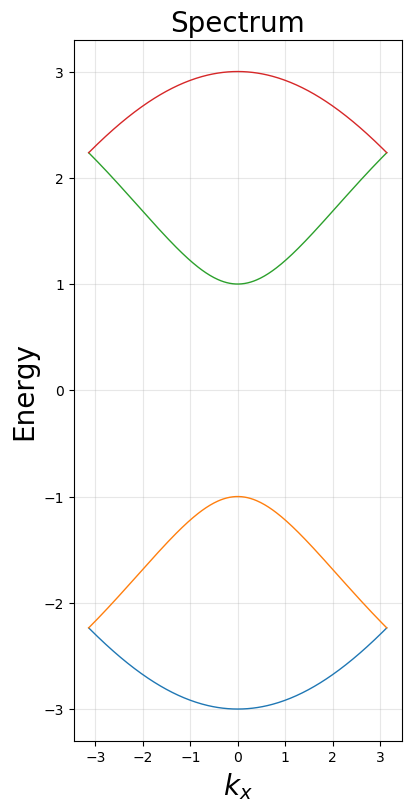

In [41]:
fig, ax = plt.subplots(1, 1, dpi=100, sharey=True, figsize=(4,8), constrained_layout=True)

ax.plot(momenta, np.array(energies)[:,:],'-',lw=1)
#ax.plot(momenta, np.array(energies)[:,:],'-',lw=1)

#ax.plot(momenta, 1*np.ones(len(momenta)),'--k',lw=1)
ax.set_title('Spectrum',fontsize=20)
ax.set_xlabel('$k_x$', fontsize=20)
ax.set_ylabel('Energy', fontsize=20)
#ax.set_ylim(0.9,1.1)
ax.grid(True,alpha=0.3)

4000.step

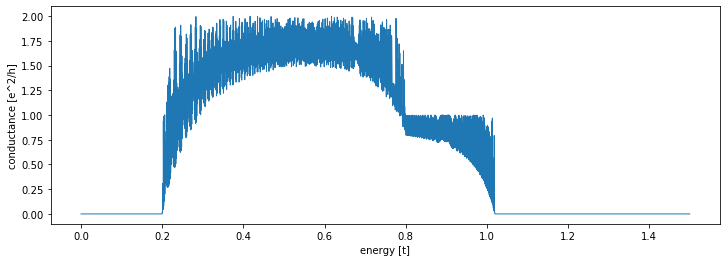

Wall time: 8min 14s


In [29]:
%%time
# well-barrier
trans10 = []
NE=4001
energy=np.linspace(0,1.5,NE)
wf=np.zeros(NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    #print(smatrix.num_propagating(1))
    #print(smatrix.out_block_coords(1))
    #print(smatrix.submatrix(1, 0))
    #print(smatrix.block_coords(0,1))
    #print(smatrix.conductance_matrix())
    #wf[i] = kwant.solvers.default.wave_function(syst, energy[i])
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission(((1,0),(0,0))))

plt.figure(figsize=(12,4))
plt.plot(energy,trans10,'-',lw=1)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

4000.step

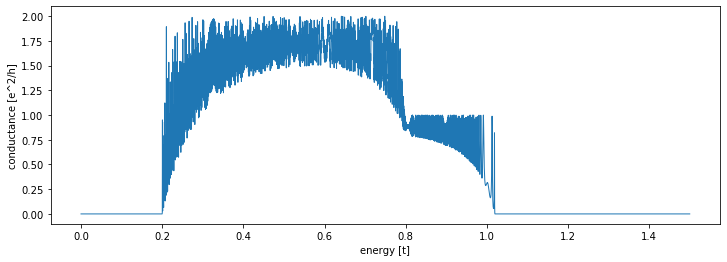

Wall time: 7min 49s


In [75]:
%%time
#barrier-well
trans10 = []
NE=4001
energy=np.linspace(0,1.5,NE)
wf=np.zeros(NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    #print(smatrix.num_propagating(1))
    #print(smatrix.out_block_coords(1))
    #print(smatrix.submatrix(1, 0))
    #print(smatrix.block_coords(0,1))
    #print(smatrix.conductance_matrix())
    #wf[i] = kwant.solvers.default.wave_function(syst, energy[i])
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission((1, 0),(0, 0)))

plt.figure(figsize=(12,4))
plt.plot(energy,trans10,'-',lw=1)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

In [6]:
#NE=20001
#energy=np.linspace(1.2,1.42,NE)
#energy,trans10=np.loadtxt('data/deneme_L=2000_NE=20001.txt')

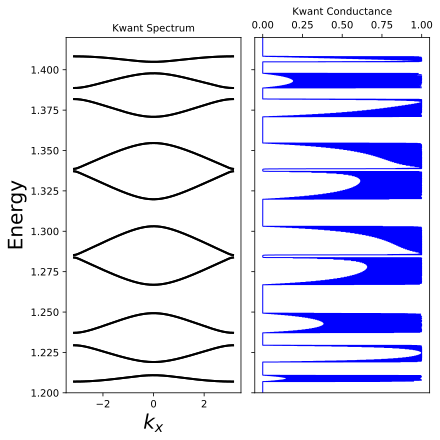

In [16]:
fig, ax = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(6,6), constrained_layout=True)

ax[0].plot(momenta, np.zeros(len(momenta)),'r--',lw=1)

ax[0].plot(momenta, np.array(energies), 'k',lw=2)
ax[0].set_title('Kwant Spectrum',fontsize=10)
ax[0].set_xlabel('$k_x$', fontsize=20)
ax[0].set_ylabel('Energy', fontsize=20)
ax[0].set_ylim(1.2,1.42)

ax[1].plot(np.array(trans10)/2,energy, 'b',lw=1)
ax[1].set_title('Kwant Conductance',fontsize=10)
ax[1].xaxis.set_ticks_position('top')

In [251]:
np.savetxt('data/deneme_L=2000_NE=20001.txt',[energy,trans10],fmt='%.18e')

100.step

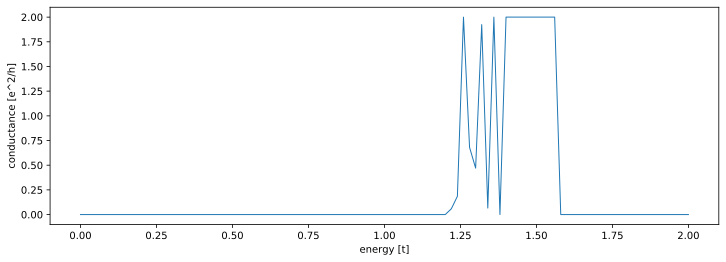

Wall time: 10.7 s


In [252]:
%%time
cond10 = []
NE=101
energy=np.linspace(0,2,NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i], params=params)
    print(f'\r{i}.step', end='', flush=True)
    cond10.append(smatrix.transmission((0, 0),(0, 0)))

plt.figure(figsize=(12,4))
plt.plot(energy,cond10,'-',lw=1)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

In [228]:
print(smatrix.submatrix(0,0).data)

In [98]:
# Discrete coordinates: x y

# Onsite element:
_cache_0 = (
np.array([[ 4.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -4.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -4.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  4.+0.j]]))
_cache_1 = (
np.array([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]]))
_cache_2 = (
np.array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]]))
def onsite(B, M):
    return (B) * (_cache_0) + (M) * (_cache_1) + (1) * (_cache_2)

# Hopping from (1, 0):
_cache_0 = (
np.array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]))
_cache_1 = (
np.array([[0.+0.j , 0.-0.5j, 0.+0.j , 0.+0.j ],
       [0.-0.5j, 0.+0.j , 0.+0.j , 0.+0.j ],
       [0.+0.j , 0.+0.j , 0.+0.j , 0.-0.5j],
       [0.+0.j , 0.+0.j , 0.-0.5j, 0.+0.j ]]))
_cache_2 = (
np.array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]]))
def hopping_1(A, B):
    return (B) * (_cache_0) + (A) * (_cache_1) + (1) * (_cache_2)

# Hopping from (0, 1):
_cache_0 = (
np.array([[-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j]]))
_cache_1 = (
np.array([[ 0. +0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0.5+0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j,  0.5+0.j],
       [ 0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j]]))
_cache_2 = (
np.array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]]))
def hopping_2(A, B):
    return (B) * (_cache_0) + (A) * (_cache_1) + (1) * (_cache_2)

In [101]:
A=1
B=0
M=0
h_cell = onsite(B, M)
h_hop = hopping_1(A, B) + hopping_2(A, B)
prop, stab = kwant.physics.modes(h_cell, h_hop)

In [114]:
prop.velocities

array([-2., -2., -2., -2.,  2.,  2.,  2.,  2.])

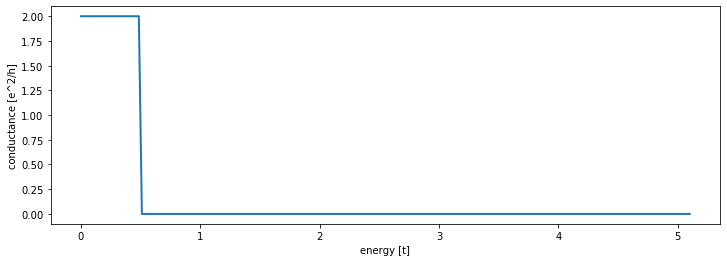

Wall time: 11.6 s


In [180]:
%%time
trans10 = []
NE=201
energy=np.linspace(1.2*0,5.1,NE)
wf=np.zeros(NE)

for i in range(len(energy)):
    smatrix = kwant.smatrix(syst, energy[i] , params=params)
    #print(smatrix.num_propagating(1))
    #print(smatrix.out_block_coords(1))
    #print(smatrix.submatrix(1, 0))
    #print(smatrix.block_coords(0,1))
    #print(smatrix.conductance_matrix())
    #wf[i] = kwant.solvers.default.wave_function(syst, energy[i])
    print(f'\r{i}.step', end='', flush=True)
    trans10.append(smatrix.transmission((1, 0), (0, 0)))

plt.figure(figsize=(12,4))
plt.plot(energy,trans10,'-',lw=2)
plt.xlabel("energy [t]")
plt.ylabel("conductance [e^2/h]")
plt.show()

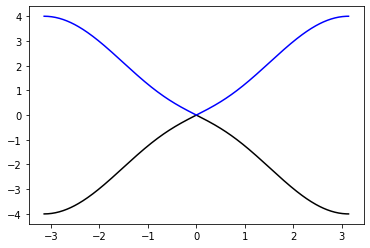

In [45]:
a=1

hamiltonian = """( M + B * (k_x**2) + V_sl(x)) * sigma_z + A * (k_x*sigma_x)"""
template = kwant.continuum.discretize(hamiltonian,grid=a)
syst = kwant.wraparound.wraparound(template).finalized()

d1=1
d2=0
V1=0.
V2=0.

def h_k(k_x):
    p = dict(k_x=k_x, **params)
    return syst.hamiltonian_submatrix(params=p)

def potential(d1,d2,V1,V2):
    xperiod=d1+d2
    def heaviside(d1,xmod):
        if xmod<d1:
            return V1
        else:
            return V2
    def super_lattice(x):
        return heaviside(d1, (x)%xperiod)
    return super_lattice

params=dict(M=0., A=1, B=1, V_sl=potential(d1,d2,V1,V2))

k_tb = np.linspace(-np.pi, np.pi, 401)
e_tb = np.array([scipy.linalg.eigvalsh(h_k(k_x=ki)) for ki in k_tb])

plt.plot(k_tb, e_tb[:,0])
plt.plot(k_tb, e_tb[:,1])

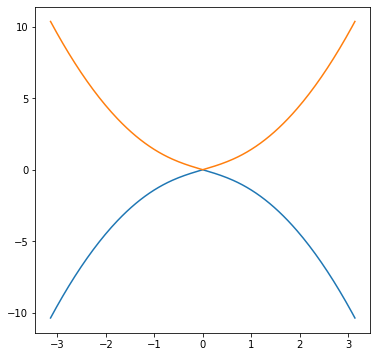

In [75]:
a=1
hamiltonian = " (M + B * k_x**2) * sigma_z + A * k_x * sigma_y "
params = dict(M=0, A=1, B=1)

h_k = kwant.continuum.lambdify(hamiltonian, locals=params)
k_cont = np.linspace(-np.pi, np.pi, 201)

e_cont=np.zeros([2,len(k_cont)])


for i in range(len(k_cont)):
    e_cont[:,i] = scipy.linalg.eigvalsh(h_k(k_x=k_cont[i]))

fig, ax = plt.subplots(1, 1, sharey=True, figsize=(6, 6))

#ax.plot(k_cont, e_cont, 'r-')
ax.plot(k_cont,np.array(e_cont)[0,:])
ax.plot(k_cont,np.array(e_cont)[1,:])
plt.show()

In [50]:
scipy.linalg.eigvalsh(h_k(k_x=k_cont[0]))

array([-16.,  16.])

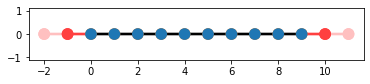

[[-1.2494997-0.20008008j -1.2494997+0.20008008j]]
[[-1.21929339-0.20503679j -1.21929339+0.20503679j]]
[[-1.19228686-0.20968108j -1.19228686+0.20968108j]]
[[-1.16790984-0.21405762j -1.16790984+0.21405762j]]
[[-1.14572821-0.21820184j -1.14572821+0.21820184j]]
[[-1.12540441-0.22214237j -1.12540441+0.22214237j]]
[[-1.10667111-0.22590271j -1.10667111+0.22590271j]]
[[-1.08931328-0.22950239j -1.08931328+0.22950239j]]
[[-1.07315553-0.23295785j -1.07315553+0.23295785j]]
[[-1.05805306-0.23628305j -1.05805306+0.23628305j]]
[[-1.04388508-0.23948996j -1.04388508+0.23948996j]]


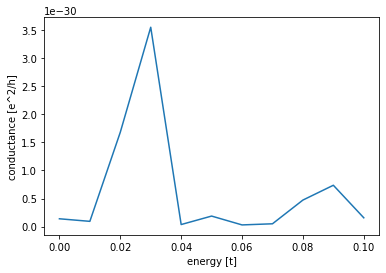

In [161]:
import kwant
from matplotlib import pyplot


def make_system(a=1, W=1, L=10, mu=0.1, t=1.0):
    # Start with an empty tight-binding system and two square lattices,
    # corresponding to up and down degree of freedom
    lat_u = kwant.lattice.square(a, name='up')
    lat_d = kwant.lattice.square(a, name='down')

    sys = kwant.Builder()

    #### Define the scattering region. ####
    sys[(lat_u(x, y) for x in range(L) for y in range(W))] = 2 * t - mu
    sys[(lat_d(x, y) for x in range(L) for y in range(W))] = mu - 2 * t

    # hoppings for both electrons and holes
    sys[lat_u.neighbors()] = -t
    sys[lat_d.neighbors()] = t

    #### Define the leads. ####
    # Symmetry for the left leads.
    sym_left = kwant.TranslationalSymmetry((-a, 0))

    # left electron up
    lead0 = kwant.Builder(sym_left)
    lead0[(lat_u(0, j) for j in range(W))] = 2 * t - mu
    lead0[lat_u.neighbors()] = -t

    # left electron down
    lead1 = kwant.Builder(sym_left)
    lead1[(lat_d(0, j) for j in range(W))] = mu - 2 * t
    lead1[lat_d.neighbors()] = t

    # Then the lead to the right
    sym_right = kwant.TranslationalSymmetry((a, 0))
    lead2 = kwant.Builder(sym_right)
    lead2.update(lead0)
    lead2.update(lead1)

    #### Attach the leads and return the system. ####
    sys.attach_lead(lead0)
    sys.attach_lead(lead1)
    sys.attach_lead(lead2)

    return sys


def plot_conductance(sys, energies):
    # Compute conductance
    data = []
    data_up = []
    data_down = []
    wf = []
    
    for energy in energies:
        smatrix = kwant.smatrix(sys, energy)
        # Conductance is N - R_ee + R_he
        print(smatrix.lead_info[0].wave_functions)
        #print(smatrix)
        data.append(smatrix.transmission(0, 0))
        
        #data_down.append(smatrix.transmission(0, 0))
        #data_up.append(smatrix.transmission(1, 0))
    #print(smatrix)
    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    #plt.figure(2)
    #pyplot.plot(data_down)
    pyplot.show()


def main():
    sys = make_system()

    # Check that the system looks as intended.
    kwant.plot(sys)

    # Finalize the system.
    sys = sys.finalized()

    plot_conductance(sys, energies=[0.010001 * i for i in range(11)])

# Call the main function if the script gets executed (as opposed to imported).
# See <http://docs.python.org/library/__main__.html>.
if __name__ == '__main__':
    main()

In [94]:
plt.plot(data_up)

NameError: name 'data_up' is not defined

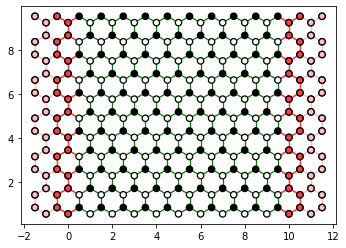

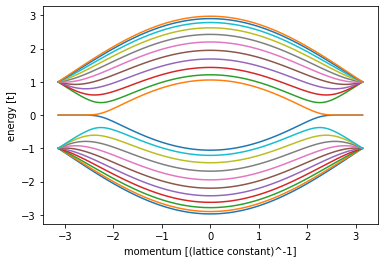

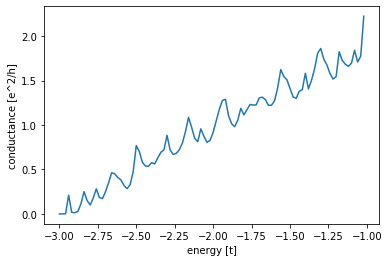

In [76]:
import kwant
from matplotlib import pyplot
from numpy import sqrt
from math import *

sys=kwant.Builder()

lat_u=kwant.lattice.honeycomb()
lat_d=kwant.lattice.honeycomb()
a,b= lat_u.sublattices
c,d= lat_d.sublattices

lx,ly=10,10

def Rectangle(pos,lx=lx,ly=ly):
    x,y=pos
    return 0<x<lx and 0<y<ly

sys[lat_u.shape(Rectangle,(1,1))]=0
sys[lat_d.shape(Rectangle,(1,1))]=0

sys[lat_u.neighbors()] = -1
sys[lat_d.neighbors()] = -1
#================================up_lead0================
def lead0_shape_u(pos,ly=ly):
    x,y=pos
    return    0<y<ly

    # left lead
sym0u = kwant.TranslationalSymmetry((-1,0))
sym0u.add_site_family(lat_u.sublattices[0], other_vectors=[(-1, 2)])
sym0u.add_site_family(lat_u.sublattices[1], other_vectors=[(-1, 2)])
lead0_u = kwant.Builder(sym0u)

lead0_u[lat_u.shape(lead0_shape_u,(1,1))]=0
lead0_u[lat_u.neighbors()] = -1

sys.attach_lead(lead0_u)
#================================down_lead0==================
def lead0_shape_d(pos,ly=ly):
    x,y=pos
    return    0<y<ly

sym0d = kwant.TranslationalSymmetry((-1,0))
sym0d.add_site_family(lat_d.sublattices[0], other_vectors=[(-1, 2)])
sym0d.add_site_family(lat_d.sublattices[1], other_vectors=[(-1, 2)])
lead0_d = kwant.Builder(sym0d)

lead0_d[lat_d.shape(lead0_shape_d,(1,1))]=0
lead0_d[lat_d.neighbors()] = -1

sys.attach_lead(lead0_d)
#=================================up_lead1==================
def lead1_shape_u(pos,ly=ly):
    x,y=pos
    return    0<y<ly

sym1u = kwant.TranslationalSymmetry((1,0))
sym1u.add_site_family(lat_u.sublattices[0], other_vectors=[(-1, 2)])
sym1u.add_site_family(lat_u.sublattices[1], other_vectors=[(-1, 2)])
lead1_u = kwant.Builder(sym1u)

lead1_u[lat_u.shape(lead1_shape_u, (1, 1))] = 0#onsite
lead1_u[lat_u.neighbors()] = -1

sys.attach_lead(lead1_u)
#=================================down_lead1==================
def lead1_shape_d(pos,ly=ly):
    x,y=pos
    return    0<y<ly

sym1d = kwant.TranslationalSymmetry((1,0))
sym1d.add_site_family(lat_d.sublattices[0], other_vectors=[(-1, 2)])
sym1d.add_site_family(lat_d.sublattices[1], other_vectors=[(-1, 2)])
lead1_d = kwant.Builder(sym1d)

lead1_d[lat_d.shape(lead1_shape_d, (1, 1))] = 0
lead1_d[lat_d.neighbors()] = -1

sys.attach_lead(lead1_d)
#============================================================
def family_colors(site):
        return 0 if (site.family == a or site.family == c)  else 1
def hopping_lw(site1, site2):
        return 0.04 if site1.family == site2.family else 0.1
def hopping_color(site1,site2):
         return 'g' if site1.family==site2.family else 'g'

kwant.plot(sys,site_color=family_colors,site_lw=0.1,
hop_lw=hopping_lw,hop_color=hopping_color,colorbar=False)

sys=sys.finalized()
#=================================================
def plot_bandstructure(flead, momenta):
        bands = kwant.physics.Bands(flead)
        energies = [bands(k) for k in momenta]

        pyplot.figure()
        pyplot.plot(momenta, energies)
        pyplot.xlabel("momentum [(lattice constant)^-1]")
        pyplot.ylabel("energy [t]")
        pyplot.show()
    # Compute the band structure of lead 0.
momenta = [-pi + 0.02 * pi * i for i in range(101)]
plot_bandstructure(sys.leads[0], momenta)
#=================================================
def plot_conductance(sys, energies):

    data = []
    for energy in energies:
        smatrix = kwant.smatrix(sys, energy)
        data.append(smatrix.transmission(2, 0))

    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [e^2/h]")
    pyplot.show()
energies=[-3+i*0.02 for i in range(100)]
#smatrix = kwant.smatrix(sys, 2)
#print(smatrix.submatrix(1,0))
plot_conductance(sys,energies)